In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


Проверим доступно ли GPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
training_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose ([ 
        transforms.ToTensor () 
        ])
)

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose ([ 
        transforms.ToTensor () 
        ])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
batch_size = 20

In [5]:
batch_size_test = 20

In [6]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size= batch_size, shuffle=True, num_workers=2) 

In [7]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size_test, shuffle=False, num_workers=2) 

Отрисуем картинку.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


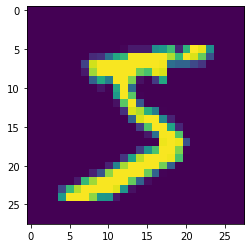

In [8]:
numpy_img = train_loader.dataset.train_data[0].numpy()
plt.imshow(numpy_img);

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv0 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3),
          nn.ReLU(),
          nn.BatchNorm2d(6)
        )
        self.pool0 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Sequential(
          nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
          nn.ReLU(),
          nn.BatchNorm2d(12)
        )
        self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=12, out_channels=18, kernel_size=3),
          nn.ReLU(),
          nn.BatchNorm2d(18)
        )
        self.conv3 = nn.Sequential(
          nn.Conv2d(in_channels=18, out_channels=24, kernel_size=3),
          nn.ReLU(),
          nn.BatchNorm2d(24)
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
          nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3),
          nn.ReLU(),
          nn.BatchNorm2d(32)
        )

        self.fc1 = nn.Linear(32, 10)
        

    def forward(self, x):
        layer0 = self.pool0(self.conv0(x))
        layer1 = self.conv1(layer0)
        layer2 = self.conv2(layer1)
        layer3 = self.pool1(self.conv3(layer2))
        layer4 = self.conv4(layer3)
        layer4 = layer4.view(layer4.size(0), -1)
        layer4 = F.relu(self.fc1(layer4))
        return layer4

In [10]:
Net = ConvNet()
Net.to(device)

ConvNet(
  (conv0): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(24, 32, kernel_size=

In [11]:
opt = torch.optim.Adam(Net.parameters(), lr=1e-3)

In [12]:
CE_loss = torch.nn.CrossEntropyLoss()

In [13]:
losses = 0
losses_plt = []
accuracy_plt = []
epoh = 4
for epoh in range(epoh):
  for count_batch, batch in enumerate(train_loader):
    Net.train()
    x_batch, y_batch = batch
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    opt.zero_grad()
    pred_target = Net(x_batch)
    loss = CE_loss(pred_target, y_batch)
    loss.backward()
    opt.step()
    losses += loss.item()
  losses_plt.append(loss.item()) 
  print(f'loss on {epoh} = {losses / len(train_loader)}')
  losses = 0
  accuracy = 0
  batches = 0
  Net.eval()
  with torch.no_grad():
    for batch in test_loader:
      x_batch, y_batch = batch
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      tmp, predict = torch.max(Net(x_batch), 1)
      for i in range(predict.shape[0]):
        batches += 1
        accuracy += int(predict[i].detach() == y_batch[i].detach())
  accuracy_plt.append(accuracy/batches)           
  print(f'accuracy_test on {epoh} = {accuracy/batches}')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss on 0 = 0.19477413295050308
accuracy_test on 0 = 0.9846
loss on 1 = 0.06594749246374704
accuracy_test on 1 = 0.9862
loss on 2 = 0.05138742899278683
accuracy_test on 2 = 0.9893
loss on 3 = 0.043036967280393586
accuracy_test on 3 = 0.9912


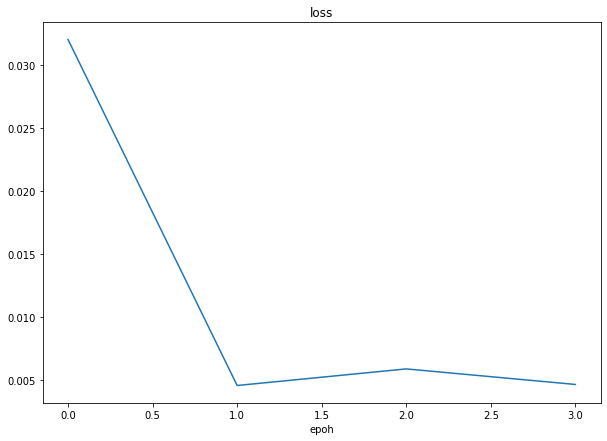

In [14]:
fig_loss = plt.figure(figsize=(10,7))
ax_loss = fig_loss.add_subplot(1, 1, 1)
plt.title("loss")
plt.title("loss")
plt.xlabel("epoh")
ax_loss.plot(np.arange(len(losses_plt)), losses_plt)

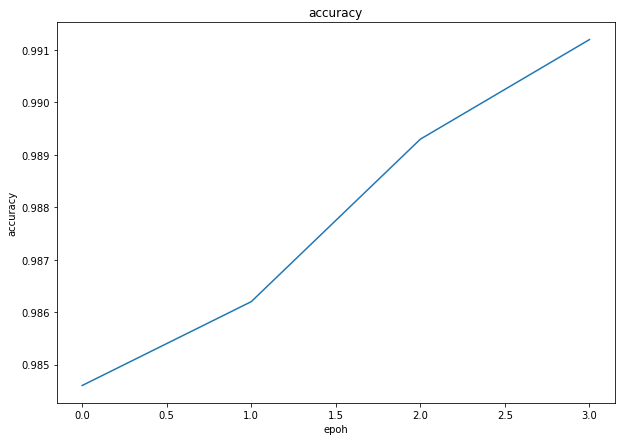

In [15]:
fig_acc = plt.figure(figsize=(10,7))
ax_acc = fig_acc.add_subplot(1, 1, 1)
plt.title("accuracy")
plt.xlabel("epoh")
plt.ylabel("accuracy")
ax_acc.plot(np.arange(len(accuracy_plt)), accuracy_plt)

In [16]:
accuracy = 0
batches = 0
Net.eval()
with torch.no_grad():
  for batch in test_loader:
    x_batch, y_batch = batch
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    tmp, predict = torch.max(Net(x_batch), 1)
    for i in range(predict.shape[0]):
      batches += 1
      accuracy += int(predict[i].detach() == y_batch[i].detach()) 
print('accuracy_test_finale', (accuracy/batches)*100)
  

accuracy_test_finale 99.11999999999999
